In [1]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    find_node_equ,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
    get_distance,
)
from amftrack.util.sys import (
    get_analysis_folders,
    get_time_plate_info_from_analysis,
    get_time_hypha_info_from_analysis,
    get_global_hypha_info_from_analysis,
)

from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-04-04 18:52:45.928103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 18:52:46.047927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-04-04 18:52:46.047971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
def get_time(exp, t, tp1):  # redefined here to avoid loop in import
    seconds = (exp.dates[tp1] - exp.dates[t]).total_seconds()
    return seconds / 3600

In [3]:
plates = ["152_20201224"]
directory_targ = directory_project
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]
# update_plate_info(directory_targ, local=True)
# all_folders = get_current_folders(directory_targ, local=True)

In [4]:
all_analysis_folders = get_analysis_folders(directory_targ)
analysis_folders_info = all_analysis_folders.loc[
    all_analysis_folders["unique_id"].isin(plates)
]
folders, time_plate_info = get_time_plate_info_from_analysis(
    analysis_folders_info, use_saved=False
)
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders_info,use_saved=False)

In [5]:
path_exp = f'{directory_targ}{analysis_folders["path_exp"].iloc[0]}'
exp = pickle.load(open(path_exp, "rb"))
exp.save_location = "/"
try:
    exp.labeled
except AttributeError:
    exp.labeled = True
load_graphs(exp, directory_targ, indexes=range(30, 32))
load_study_zone(exp)

In [6]:
for t in range(exp.ts):
    exp.load_tile_information(t)

In [14]:
hyph = [hyph for hyph in exp.hyphaes if hyph.end.label == 0][0]
hyph.root = Node(44, exp)
hyph = [hyph for hyph in exp.hyphaes if hyph.end.label == 6][0]
hyph.root = Node(147, exp)

In [89]:
list_hyph = [0, 6, 118, 58, 1, 85]
# list_hyph = [521770,535353,509730]
# list_hyph = [509730]
# list_hyph = [1]

In [7]:
tf = 31

list_hyph_obj = [
    hyph
    for hyph in exp.hyphaes
    if hyph.end.is_in(tf)
    and len(hyph.root.ts()) >= 1
    and np.linalg.norm(hyph.end.pos(tf) - hyph.get_root(tf).pos(tf)) >= 1e4
]
list_hyph = [hyph.end.label for hyph in list_hyph_obj]

In [8]:
list_hyph_obj

[Hyphae(107641,107631),
 Hyphae(108172,144933),
 Hyphae(108564,108561),
 Hyphae(109388,109385),
 Hyphae(109962,109961),
 Hyphae(110301,110296),
 Hyphae(110305,110296),
 Hyphae(110908,419760),
 Hyphae(112077,112048),
 Hyphae(112106,109918),
 Hyphae(112750,112777),
 Hyphae(113191,113193),
 Hyphae(116321,116320),
 Hyphae(116383,116379),
 Hyphae(116650,116692),
 Hyphae(116894,116864),
 Hyphae(116981,119528),
 Hyphae(117110,117122),
 Hyphae(117143,117166),
 Hyphae(117816,117806),
 Hyphae(117936,118004),
 Hyphae(118202,118197),
 Hyphae(119538,201171),
 Hyphae(119668,119661),
 Hyphae(119674,112021),
 Hyphae(119789,119802),
 Hyphae(119930,119946),
 Hyphae(121532,121583),
 Hyphae(121536,121589),
 Hyphae(121946,121968),
 Hyphae(122018,122027),
 Hyphae(122069,76614),
 Hyphae(122085,122057),
 Hyphae(122700,122712),
 Hyphae(123729,123731),
 Hyphae(124657,66690),
 Hyphae(124916,115331),
 Hyphae(124951,124982),
 Hyphae(125485,125472),
 Hyphae(125891,125902),
 Hyphae(125901,124164),
 Hyphae(125903,125

In [23]:
def get_length_fast(edge, t):
    return np.linalg.norm(edge.begin.pos(t) - edge.end.pos(t))

In [50]:
actual_list_hyph = []
all_distances = []
all_time_distances = []

for end in list_hyph:
    hyph_label = end
    hyph = [hyph for hyph in exp.hyphaes if hyph.end.label == end][0]
    t0 = hyph.ts[0]
    exp = hyph.experiment
    thresh = 1600
    junctions_found = [hyph.end.neighbours(t0)[0]]
    ts = []
    mult = []
    speeds = []
    print(end)
    select = time_hypha_info.loc[time_hypha_info["end"] == end]

    for t in hyph.ts:
        select_t = select.loc[select["timestep"] == t - 1]
        speed = select_t["speed"].iloc[0] if len(select_t) > 0 else -1
        if t < tf:
            try:
                G = exp.nx_graph[t]
                G = G.subgraph(nx.node_connected_component(G, hyph.end.label))
                if hyph.end.degree(t) == 1:
                    nodes, edges = hyph.get_nodes_within(t)
                    potentials = []
                    nodes = [Node(node, exp) for node in nodes]
                    try:
                        last_junction_index = nodes.index(junctions_found[-1])
                    except:
                        last_junction_index = 0
                    for node in nodes[last_junction_index + 1 : -1]:
                        dist = np.linalg.norm(node.pos(t) - hyph.end.pos(t))
                        # To avoid detecting two times the same  node with different labels
                        dists_junction_found = [np.inf] + [
                            np.linalg.norm(node.pos(t) - nodo.pos(t))
                            for nodo in junctions_found
                            if nodo.is_in(t)
                        ]
                        if (
                            dist < thresh
                            and min(dists_junction_found) > 40
                            and (node not in junctions_found)
                        ):
                            extra_hypha_neighbours = [
                                nodo for nodo in node.neighbours(t) if nodo not in nodes
                            ]
                            f = lambda edge: np.log(
                                edge.width(edge.ts()[-1])
                                * get_length_fast(edge, edge.ts()[-1])
                                * edge.end.degree(edge.ts()[-1])
                                * edge.begin.degree(edge.ts()[-1])
                            )

                            edges = [
                                Edge(node, nodo, exp) for nodo in extra_hypha_neighbours
                            ]
                            is_rh = [f(edge) >= 10 for edge in edges]
                            tips = [
                                nodo
                                for nodo in extra_hypha_neighbours
                                if nx.edge_connectivity(G, nodo.label, node.label) == 1
                            ]
                            # if len(tips) == node.degree(t) - 2:

                            if len(tips) == node.degree(t) - 2 and np.any(is_rh):
                                junctions_found.append(node)
                                mult.append(node.degree(t) - 2)
                                ts.append(t)
                                speeds.append(speed)
            except nx.exception.NetworkXNoPath:
                print(hyph, t)

    junctions_found_tf = [find_node_equ(node, tf) for node in junctions_found]
    junctions_found_tf = [
        node
        for node in junctions_found_tf
        if nx.has_path(exp.nx_graph[tf], node.label, junctions_found_tf[0].label)
    ]
    junctions_found_label = [node.label for node in junctions_found_tf]
    t_real = [get_time(exp, t0, t) for t in ts]
    try:

        distances = [
            get_distance(junctions_found_tf[i], junctions_found_tf[i + 1], tf)
            for i in range(1, len(junctions_found_tf) - 1)
        ]
        time_distances = [
            distance / speeds[i + 1] for i, distance in enumerate(distances)
        ]
        all_distances += distances
        all_time_distances += time_distances

        np.save(f"branches/ts_{hyph_label}_auto", t_real)
        np.save(f"branches/distances_{hyph_label}_auto", distances)
        np.save(f"branches/times_{hyph_label}_auto", time_distances)

        actual_list_hyph.append(end)
    except nx.exception.NetworkXNoPath:
        print("problem with", end)

0


TypeError: 'NoneType' object is not subscriptable

(array([ 7.,  5.,  4., 10.,  2.,  3.,  2.,  3.,  0.,  3.,  0.,  1.,  0.,
         0.,  2.]),
 array([ 0.24004585,  2.084487  ,  3.92892816,  5.77336931,  7.61781047,
         9.46225162, 11.30669278, 13.15113393, 14.99557509, 16.84001624,
        18.6844574 , 20.52889855, 22.37333971, 24.21778086, 26.06222202,
        27.90666317]),
 <BarContainer object of 15 artists>)

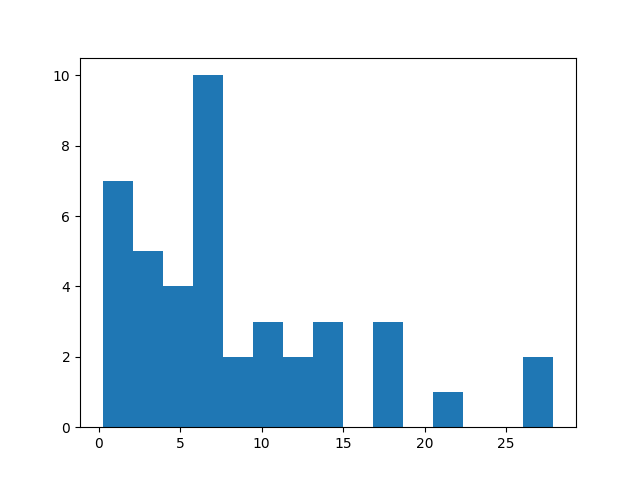

In [97]:
fig, ax = plt.subplots()

ax.hist(all_time_distances, 15)

(array([4., 5., 6., 5., 0., 1., 1., 2., 2., 0., 1., 2.]),
 array([ 117.64414179,  772.11284633, 1426.58155088, 2081.05025542,
        2735.51895997, 3389.98766451, 4044.45636906, 4698.92507361,
        5353.39377815, 6007.8624827 , 6662.33118724, 7316.79989179,
        7971.26859633]),
 <BarContainer object of 12 artists>)

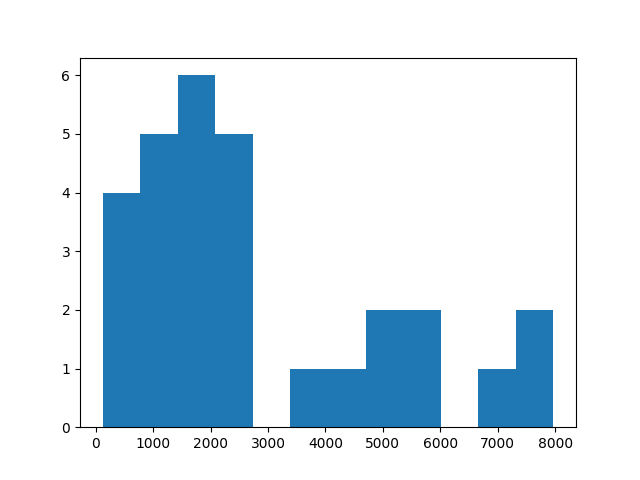

In [92]:
fig, ax = plt.subplots()

ax.hist(all_distances, 12)

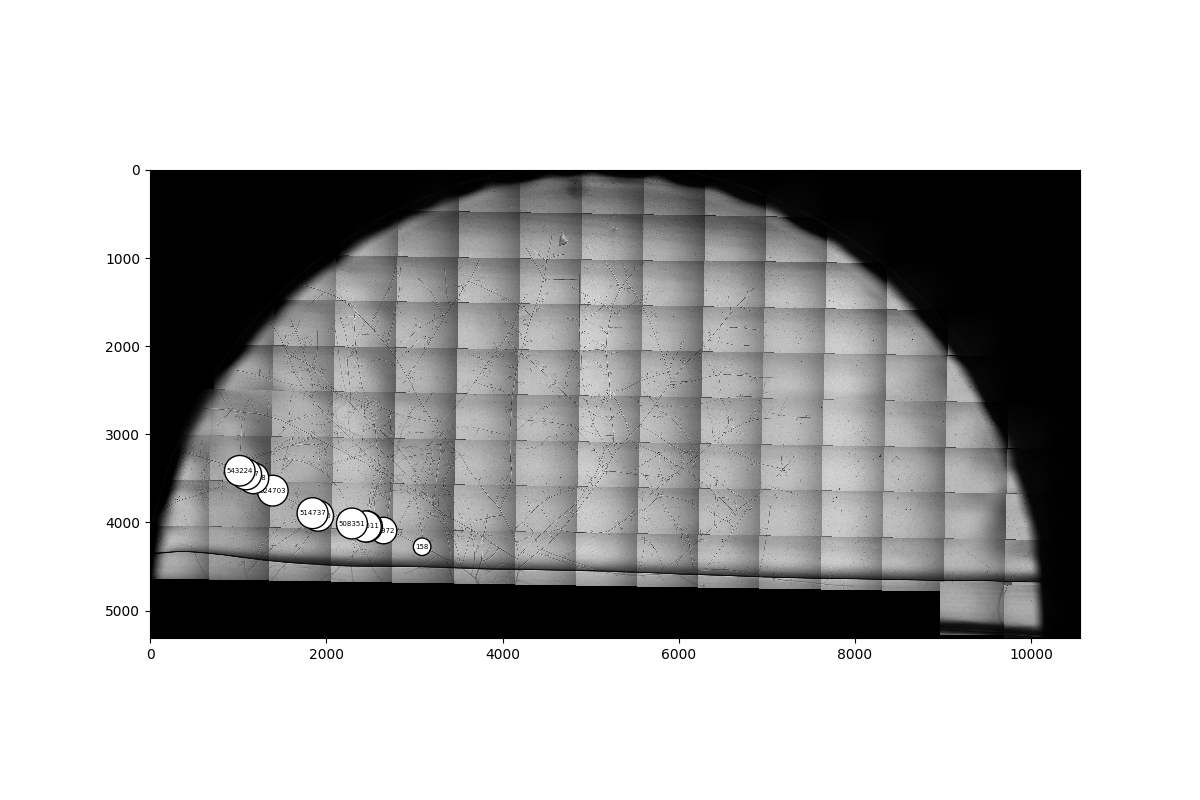

In [98]:
ax = plot_full_image_with_features(
    exp,
    tf,
    nodes=junctions_found_tf
    # nodes = [Node(607965,exp),Node(518481,exp)]
)

In [43]:
nodes = [hyph.end for hyph in list_hyph_obj] + [
    hyph.get_root(tf) for hyph in list_hyph_obj
]
# nodes = [hyph.end for hyph in list_hyph_obj if hyph.end.is_in(tf)]

In [45]:
nodes = [hyph.end for hyph in exp.hyphaes if hyph.end.is_in(tf)]

In [46]:
nodes

[Node(0), Node(1), Node(2), Node(105), Node(134), Node(137), Node(139)]

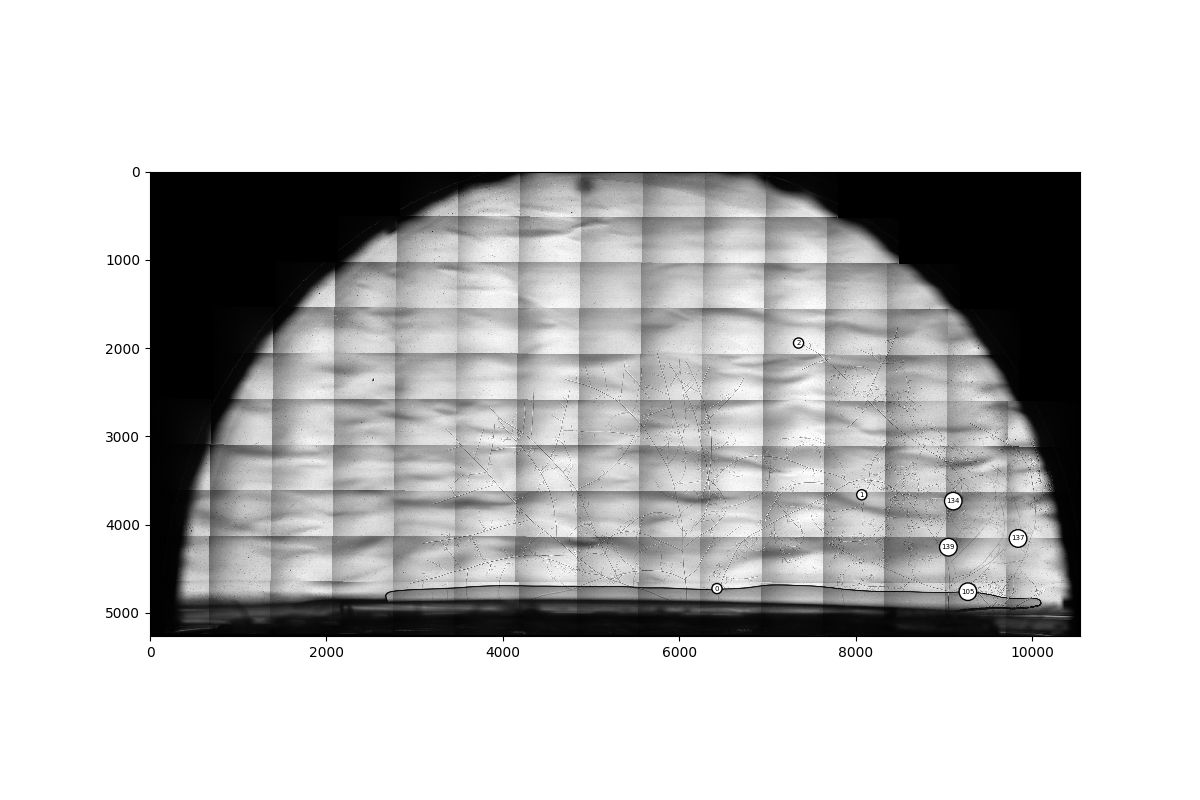

In [47]:
plt.close("all")
ax = plot_full_image_with_features(exp, tf, nodes=nodes)